<a href="https://colab.research.google.com/github/jungeun919/Pytorch_study/blob/main/Pytorch_Tutorial/Transfer_Learning_for_Computer_Vision_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전이 학습

- ConvNet 미세조정

  무작위 초기화 대신 사전 훈련된 네트워크로 네트워크를 초기화

- ConvNet as fixed feature extractor

  최종 연결 계층을 제외한 모든 네트워크에 대한 가중치를 고정

  마지막 완전 연결 계층은 임의 가중치가 있는 새 계층으로 대체, 이 계층만 훈련

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


plt.ion()

# Load Data

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/pytorch_tutorial/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Visualize a few images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


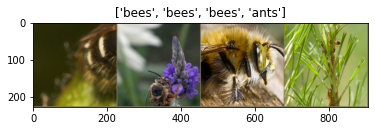

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training Model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapesd = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(
        time_elapesd // 60, time_elapesd % 60))
    print("Best val Acc: {:4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.was_training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title("Predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convert

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


# Train & Evaluate

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6000 Acc: 0.6885
val Loss: 0.3016 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.6460 Acc: 0.7213
val Loss: 0.3442 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.4865 Acc: 0.8074
val Loss: 0.2261 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4782 Acc: 0.8033
val Loss: 0.2831 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4666 Acc: 0.7787
val Loss: 0.3421 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4275 Acc: 0.8361
val Loss: 0.3692 Acc: 0.8366

Epoch 6/24
----------
train Loss: 0.4483 Acc: 0.8197
val Loss: 0.2004 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3281 Acc: 0.8607
val Loss: 0.1918 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3239 Acc: 0.8770
val Loss: 0.2139 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3206 Acc: 0.8648
val Loss: 0.1613 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2775 Acc: 0.8730
val Loss: 0.1493 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2835 Acc: 0.8730
val Loss: 0.1473 Acc: 0.9412

Epoch 12/24
----------
t

# ConvNet as fixed feature extractor

In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train & Evaluate

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6733 Acc: 0.6434
val Loss: 0.2167 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5794 Acc: 0.7869
val Loss: 0.1667 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4382 Acc: 0.7869
val Loss: 0.1888 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4023 Acc: 0.8279
val Loss: 0.1685 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4567 Acc: 0.8115
val Loss: 0.1642 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4801 Acc: 0.7705
val Loss: 0.1590 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.6041 Acc: 0.7500
val Loss: 0.1636 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4135 Acc: 0.8074
val Loss: 0.1990 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3825 Acc: 0.8361
val Loss: 0.1762 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3629 Acc: 0.8402
val Loss: 0.1617 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.2383 Acc: 0.9180
val Loss: 0.1969 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2954 Acc: 0.8484
val Loss: 0.1873 Acc: 0.9346

Epoch 12/24
----------
t